In [1]:
pip install tensorflow

  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462 kB)
  Using cached numpy-1.19.5-cp39-cp39-manylinux2010_x86_64.whl (14.9 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached grpcio-1.32.0-cp39-cp39-linux_x86_64.whl
  Using cached absl_py-0.15.0-py3-none-any.whl (132 kB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached wrapt-1.12.1-cp39-cp39-linux_x86_64.whl
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.46.1
    Uninstalling grpcio-1.46.1:
      Successfully uninstalled grpcio-1.46.1
 

In [5]:
pip install opencv-python

  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install opencv-python-headless

  Using cached opencv_python_headless-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (48.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install scikit-image

     |████████████████████████████████| 14.0 MB 3.6 MB/s eta 0:00:01
  Using cached PyWavelets-1.3.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.9 MB)
     |████████████████████████████████| 2.0 MB 106.8 MB/s eta 0:00:01
  Using cached tifffile-2022.5.4-py3-none-any.whl (195 kB)
     |████████████████████████████████| 3.4 MB 91.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!wget data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

In [16]:
!wget data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip

--2022-05-06 20:12:50--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip [following]
--2022-05-06 20:12:51--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448993893 (428M) [application/zip]
Saving to: ‘DIV2K_valid_HR.zip’

DIV2K_valid_HR.zip  100%[===================>] 428.19M  13.5MB/s    in 33s     

2022-05-06 20:13:24 (12.9 MB/s) - ‘DIV2K_valid_HR.zip’ saved [448993893/448993893]



In [17]:
from zipfile import ZipFile
zf = ZipFile('DIV2K_train_HR.zip', 'r')
zf.extractall('data') # zip all image in folder images 
zf.close()

In [18]:
from zipfile import ZipFile
zf = ZipFile('DIV2K_valid_HR.zip', 'r')
zf.extractall('data') # zip all image in folder images 
zf.close()

In [28]:
import sys
import numpy
import matplotlib
import skimage
import tensorflow as tf  
import cv2
from skimage.transform import resize, rescale 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from skimage import measure  
#import measure.compare_ssim as ssim
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os  
import matplotlib.pyplot as plt

# Load dataset low resolution

In [29]:
def train_low(path,size,scale):
    names = sorted(os.listdir(path)) # get  all items  in path
    print(len(names)) # print no. of img
    data = []
    for name in names:
        fpath = path + name  # add name  of img to the path
        img = cv2.imread(fpath, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size,size),cv2.INTER_CUBIC)  # downsample bicubic
        img = cv2.resize(img, ((size*scale),(size*scale)),cv2.INTER_CUBIC) # make  upsamble bicubic to model 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb) 
        img = img[:, :, 0].astype(float) / 255   # y is the luma
        shape = img.shape
        data.append(img) 
    data = np.array(data) 
    return data

In [30]:
def train_high(path,size,scale):
    names = sorted(os.listdir(path))
    print(len(names))
    data = []
    for name in names:
        fpath = path + name
        img = cv2.imread(fpath, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size,size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img = img[:, :, 0].astype(float) / 255   # y is the luma.
        shape = img.shape
        data.append(img) # no. of images  #900 ---->(w,h)
    data = np.array(data)   # (no. of image, w, h) 
    return data

In [31]:
# define the SRCNN model
def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers  #    (1392, 2040, 3)
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True, input_shape=(None,None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='same', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])
    
    return SRCNN

In [32]:
srcnn = model()
srcnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 1)     1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


In [9]:
Xtrain_high =train_high('./data/train_data/DIV2K_train_HR/',256,2)

900


In [10]:
Xtrain_high.shape

(900, 256, 256)

In [33]:
y_train_low=train_low('./data/train_data/DIV2K_train_HR/',64,4)

900


In [36]:
y_train_low.shape

(900, 256, 256)

Text(0.5, 1.0, 'high resolution ')

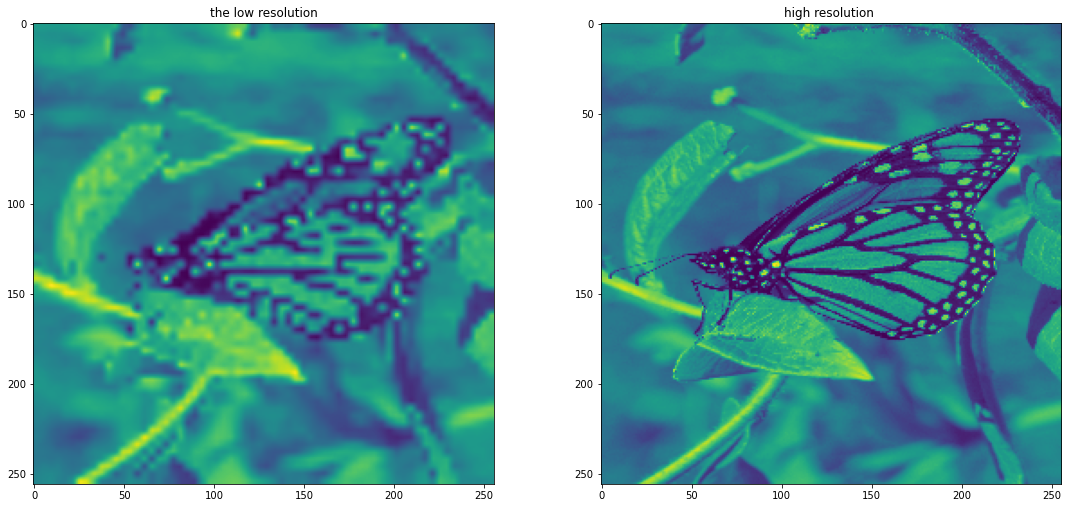

In [37]:
plt.figure(figsize = (100, 100))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(y_train_low[5])
plt.title("the low resolution")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(Xtrain_high[5])
plt.title("high resolution ")

In [38]:
low= numpy.zeros((y_train_low.shape[0], y_train_low.shape[1], y_train_low.shape[2], 1), dtype=float)
low[:, :, :, 0]=y_train_low[:, :, :].astype(float)
low.shape

(900, 256, 256, 1)

In [39]:
high= numpy.zeros((Xtrain_high.shape[0], Xtrain_high.shape[1], Xtrain_high.shape[2], 1), dtype=float)
high[:, :, :, 0]=Xtrain_high[:, :, :].astype(float)
high.shape

(900, 256, 256, 1)

In [40]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [41]:
history=srcnn.fit( low, high, batch_size=10, validation_split=0.2, shuffle=True, epochs=100,callbacks=[callback]) 

Epoch 1/100
72/72 [==============================] - 8s 103ms/step - loss: 0.0543 - accuracy: 0.0120 - val_loss: 0.0143 - val_accuracy: 0.0089
Epoch 2/100
72/72 [==============================] - 7s 101ms/step - loss: 0.0142 - accuracy: 0.0122 - val_loss: 0.0134 - val_accuracy: 0.0089
Epoch 3/100
72/72 [==============================] - 7s 102ms/step - loss: 0.0138 - accuracy: 0.0122 - val_loss: 0.0132 - val_accuracy: 0.0089
Epoch 4/100
72/72 [==============================] - 7s 102ms/step - loss: 0.0136 - accuracy: 0.0105 - val_loss: 0.0131 - val_accuracy: 0.0089
Epoch 5/100
72/72 [==============================] - 7s 103ms/step - loss: 0.0132 - accuracy: 0.0100 - val_loss: 0.0131 - val_accuracy: 0.0089
Epoch 6/100
72/72 [==============================] - 7s 103ms/step - loss: 0.0135 - accuracy: 0.0114 - val_loss: 0.0131 - val_accuracy: 0.0089
Epoch 7/100
72/72 [==============================] - 7s 103ms/step - loss: 0.0138 - accuracy: 0.0128 - val_loss: 0.0131 - val_accuracy: 0.0089

Epoch 58/100
72/72 [==============================] - 8s 110ms/step - loss: 0.0131 - accuracy: 0.0109 - val_loss: 0.0129 - val_accuracy: 0.0089
Epoch 59/100
72/72 [==============================] - 8s 110ms/step - loss: 0.0133 - accuracy: 0.0108 - val_loss: 0.0129 - val_accuracy: 0.0089
Epoch 60/100
72/72 [==============================] - 8s 111ms/step - loss: 0.0130 - accuracy: 0.0117 - val_loss: 0.0129 - val_accuracy: 0.0089
Epoch 61/100
72/72 [==============================] - 8s 110ms/step - loss: 0.0131 - accuracy: 0.0121 - val_loss: 0.0129 - val_accuracy: 0.0089
Epoch 62/100
72/72 [==============================] - 8s 107ms/step - loss: 0.0138 - accuracy: 0.0130 - val_loss: 0.0129 - val_accuracy: 0.0089
Epoch 63/100
72/72 [==============================] - 8s 105ms/step - loss: 0.0134 - accuracy: 0.0141 - val_loss: 0.0129 - val_accuracy: 0.0089
Epoch 64/100
72/72 [==============================] - 7s 104ms/step - loss: 0.0140 - accuracy: 0.0119 - val_loss: 0.0129 - val_accuracy:

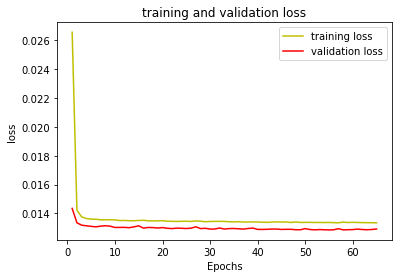

In [42]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label="training loss")
plt.plot(epochs,val_loss,'r',label="validation loss")
plt.title("training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

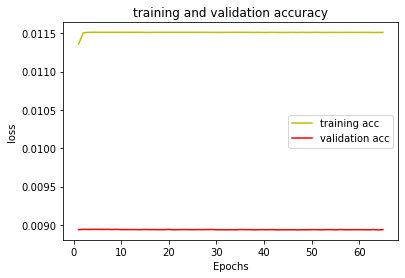

In [43]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,acc,'y',label="training acc")
plt.plot(epochs,val_acc,'r',label="validation acc")
plt.title("training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [44]:
srcnn.save('srcnn_model_4x_65epoch.h5')